**MUQING WEN, ZHOUYI QIAN**

Spring 2023

CS 443: Bio-inspired Machine Learning

#### Week 2: Motor neurons and the Outstar learning rule

# Project 3: Outstar Learning and Motor Control

This week will focus on implementing the motorneurons, which serve as the source layer in the Outstar neural network. These neurons sense the current state of the arm, which in turn will rely on Outstar learning to activate the appropriate muscles so that the arm can progressively move toward the target.

This week will also involve implementing and exploring how the Outstar learning rule works.

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 16})
plt.show()

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 3: Create motor neurons to sense the current state of the arm 

The motor neurons are the source cells in the Outstar network. Like `Muscles`, the `MotorNeurons` class represents not one unit, but rather ALL the neurons together in one object (*for efficiency*). Each neuron is tuned to a COMBINATION of:
1. joint angles (3)
2. direction of hand to the target.

For example, one neuron might activate maximally when the 3 joints have angles of (0°, 0°, 0°) and the target is located at a 30° angle from the current hand position. These are the (4) **preferred angles** of the neuron. Another neuron might activate maximally when the 3 joints have angles of (15°, 0°, 0°) and the target is located at a 45° angle from the current hand position, and so on. This neuron prefers the same elbow and wrist angles (2nd and 3rd entries of tuple) as the first neuron, but different shoulder (1st entry of tuple) and target angles. **Every neuron is tuned to a different combination of these four angles.**

We want to simulate enough "preferred" angles so that we get good sensitivity (coverage) of the 4D space. Our approach to make this happen is to evenly sample preferred angles within each joint's ergonomic range. For example, the valid range of shoulder angles is -90° to 90° and we might make neurons tuned to 7 angles evenly spaced along this 180° range (e.g. -90°, -60°, ...).

Your task is to implement the `MotorNeurons` class. This is more complex so let's break it down into several steps.

In [3]:
from joint import Joint
from motor_neurons import MotorNeurons

### 3a. Joint angle and direction tuning of `MotorNeurons`

Implement the `MotorNeurons` constructor and methods through `initialize_pref_angles` (called from constructor). This will establish the combination of preferred angles for each neuron.

#### Test (1/2): Tuning small example

The following test code uses "fake" joint angle ranges to help illustrate how the angle tuning works.

- **Shoulder:** Ergonomic range: `[1, 5]`. `3` preferred joint angles.
- **Elbow:** Ergonomic range: `[10, 12]`. `3` preferred joint angles.
- **Wrist:** Ergonomic range: `[22, 26]`. `3` preferred joint angles.
- **Movement directions:** Ergonomic range: `[-π, π]`. `2` preferred angles.

We are evenly sampling within each range when generating preferred angles, which means the following preferred angles:

- **Shoulder:** `[1, 2, 5]`
- **Elbow:** `[10, 11, 12]`
- **Wrist:** `[22, 24, 26]`
- **Movement directions:** `[-3.142, 3.142]`

The array that you are to generate contains ALL COMBINATIONS of the above angles, which represent the preferred angle combinations for each neuron (there is one neuron per each combination). So shape of final array = `(4 preferred angle types, 3*3*3*2=54 neurons)`.

So (in transposed form) this looks like:

```
[1, 10, 22, -3.142]
[1, 10, 22, 3.142]
[1, 10, 24, -3.142]
[1, 10, 24, 3.142]
[1, 10, 26, -3.142]
[1, 10, 26, 3.142]
[1, 11, 22, -3.142]
...
[5, 12, 26, 3.142]
```

Each row is neuron `i`'s preferred set of arm joint angles / relative direction to the target (i.e. angles that the neuron "wants to see" or that "makes the neuron the most happy").

In [4]:
def create_joints_pref_test_simple():
    shoulder = Joint('shoulder', 0, 0, angle_limits=[1, 5])
    elbow = Joint('elbow', 0, 28, angle_limits=[10, 12])
    wrist = Joint('wrist', 0, 28+28, angle_limits=[22, 26])
    return [shoulder, elbow, wrist]

def create_joints_pref_test():
    shoulder = Joint('shoulder', 0, 0, angle_limits=[0, np.pi])
    elbow = Joint('elbow', 0, 28, angle_limits=[-np.pi/3, np.pi/4])
    wrist = Joint('wrist', 0, 28+28, angle_limits=[-np.pi, 0])
    return [shoulder, elbow, wrist]

In [6]:
test_sim_joints = create_joints_pref_test_simple()
test_sim_mn = MotorNeurons(test_sim_joints, n_joint_angle_prefs=3, n_dir_angle_prefs=2)
test_sim_pref_angles = test_sim_mn.get_pref_angles()

print('Test 1:')
print(f'You created {test_sim_mn.get_num_units()} neurons and there should be 54')
print(f'The shape of your preferred angles is {test_sim_pref_angles.shape} and it should be (4, 54)')
print('Your transposed preferred angles are (see cell above for expected result):')
print(test_sim_pref_angles.T)

Test 1:
You created 54 neurons and there should be 54
The shape of your preferred angles is (4, 54) and it should be (4, 54)
Your transposed preferred angles are (see cell above for expected result):
[[ 1.    10.    22.    -3.142]
 [ 1.    10.    22.     3.142]
 [ 1.    10.    24.    -3.142]
 [ 1.    10.    24.     3.142]
 [ 1.    10.    26.    -3.142]
 [ 1.    10.    26.     3.142]
 [ 1.    11.    22.    -3.142]
 [ 1.    11.    22.     3.142]
 [ 1.    11.    24.    -3.142]
 [ 1.    11.    24.     3.142]
 [ 1.    11.    26.    -3.142]
 [ 1.    11.    26.     3.142]
 [ 1.    12.    22.    -3.142]
 [ 1.    12.    22.     3.142]
 [ 1.    12.    24.    -3.142]
 [ 1.    12.    24.     3.142]
 [ 1.    12.    26.    -3.142]
 [ 1.    12.    26.     3.142]
 [ 3.    10.    22.    -3.142]
 [ 3.    10.    22.     3.142]
 [ 3.    10.    24.    -3.142]
 [ 3.    10.    24.     3.142]
 [ 3.    10.    26.    -3.142]
 [ 3.    10.    26.     3.142]
 [ 3.    11.    22.    -3.142]
 [ 3.    11.    22.     3

#### Test (2/2): Larger tuning example

In [7]:
print('Test 2:')
test_sim_joints = create_joints_pref_test()
test_sim_mn = MotorNeurons(test_sim_joints, n_joint_angle_prefs=5, n_dir_angle_prefs=3)
test_sim_pref_angles = test_sim_mn.get_pref_angles()

print(f'You created {test_sim_mn.get_num_units()} neurons and there should be 375')
print(f'The shape of your preferred angles is {test_sim_pref_angles.shape} and it should be (4, 375)')

for i, joint in enumerate(test_sim_joints):
    u = np.unique(test_sim_pref_angles[i])
    print(f'{joint.get_name()}: Your unique preferred angles = {u}')
    print(f'  There are {len(u)} and there should be 5')
    if i < 3 and len(u) != 5 or i == 3 and len(u) != 3:
        print(f'  There are neurons tuned to more preferred angles for Joint {joint.get_name()} than expected!')
    lim = joint.get_limits()
    if u.min() < lim[0] or u.max() > lim[1]:
        print(f'There are neurons tuned to Joint {joint.get_name()} angles outside the valid range!')

Test 2:
You created 375 neurons and there should be 375
The shape of your preferred angles is (4, 375) and it should be (4, 375)
shoulder: Your unique preferred angles = [0.    0.785 1.571 2.356 3.142]
  There are 5 and there should be 5
elbow: Your unique preferred angles = [-1.047 -0.589 -0.131  0.327  0.785]
  There are 5 and there should be 5
wrist: Your unique preferred angles = [-3.142 -2.356 -1.571 -0.785  0.   ]
  There are 5 and there should be 5


### 3b. Implement motorneuron `net_in`

For `net_in`, each neuron `j` determines how similar the arm's current set of 3 joint angles ($\theta_k$, shape=`(3,)`) and current arm movement direction ($\theta_{target}$) are to its preferred set of 4 angles ($\theta_{target}^{pref,j}, \theta_{1}^{pref,j}, \theta_{2}^{pref,j}, \theta_{3}^{pref,j}$):

$$
netIn_{j} = 4 - \frac{1}{\pi} \left(\left|\theta_{target} - \theta_{target}^{pref,j} \right| + \sum_{k=1}^3 \left|\theta_{k} - \theta_{k}^{pref,j} \right|  \right)
$$

where $|a|$ is the absolute value of $a$.

If the current state of the arm is similar to a motorneuron's set of preferred angles (differences in equation will be $\approx 0$ ), the activation will be LARGE (because 4-0 = 4). If the current state of the arm is very different to a motor neuron's set of preferred angles (differences in equation will be LARGE), the activation will be $\approx$ 0 or become negative.

#### Test: `net_in` numeric

In [10]:
joints = [Joint('j1', 0, 1, angle_limits=(-7, -3)),
          Joint('j2', 1, 2, angle_limits=(10, 15)),
          Joint('j3', 2, 3, angle_limits=(-2, 2))]

neurons = MotorNeurons(joints, n_joint_angle_prefs=1, n_dir_angle_prefs=5)
# Set preferred angles to make sure everyone's preferred angles are the same in this test
pref_angles = np.array([[-7.   , -7.   , -7.   , -7.   , -7.   ],
       [10.   , 10.   , 10.   , 10.   , 10.   ],
       [-2.   , -2.   , -2.   , -2.   , -2.   ],
       [-3.142, -1.885, -0.628,  0.628,  1.885]])
neurons.set_pref_angles(pref_angles)
print(75*'*')
print(f'Test 1:\nThe net input to your neurons are')
print(f' {neurons.net_in(np.array([-7, 10, -2]), -3.142)}')
print(f'and they should be (different order is ok):\n [4.  3.6 3.2 2.8 2.4]')

print(75*'*')
print(f'Test 2:\nThe net input to your neurons are')
print(f' {neurons.net_in(np.array([-7, 10, -2]), 0.628)}')
print(f'and they should be (different order is ok):\n [2.8 3.2 3.6 4.  3.6]')

print(75*'*')
print(f'Test 3:\nThe net input to your neurons are')
print(f' {neurons.net_in(np.array([-3.86, 13.14, 1.14]), 0)}')
print(f'and they should be (different order is ok):\n [0.001 0.402 0.802 0.802 0.402]')

print(75*'*')
print(f'Test 4:\nThe net input to your neurons are')
print(f' {neurons.net_in(np.array([-7, 13.14, 1.14]), 1.256)}')
print(f'and they should be (different order is ok):\n [0.601 1.001 1.401 1.801 1.801]')

***************************************************************************
Test 1:
The net input to your neurons are
 [4.  3.6 3.2 2.8 2.4]
and they should be (different order is ok):
 [4.  3.6 3.2 2.8 2.4]
***************************************************************************
Test 2:
The net input to your neurons are
 [2.8 3.2 3.6 4.  3.6]
and they should be (different order is ok):
 [2.8 3.2 3.6 4.  3.6]
***************************************************************************
Test 3:
The net input to your neurons are
 [0.001 0.402 0.802 0.802 0.402]
and they should be (different order is ok):
 [0.001 0.402 0.802 0.802 0.402]
***************************************************************************
Test 4:
The net input to your neurons are
 [0.601 1.001 1.401 1.801 1.801]
and they should be (different order is ok):
 [0.601 1.001 1.401 1.801 1.801]


#### Test: `net_in` visual

This test should help visualize and interpret what the net_in values mean.

Run the following code to generate a joint, hand, and arm configuration used for this test. The plot should show the arm fully extended straight and to the right (on positive x axis).

In [11]:
from joint import EndEffector
from model_arm import Arm

In [12]:
def create_joints_and_hand_for_visual_test():
    shoulder = Joint('shoulder', 0, 0, angle_limits=[-np.pi/2, np.pi])
    elbow = Joint('elbow', 0, 28, angle_limits=[0, np.pi])
    wrist = Joint('wrist', 0, 28+28, angle_limits=[-np.pi/2, np.pi/2])
    hand = EndEffector('hand', 16+28+28)
    
    joints = [shoulder, elbow, wrist]
    return joints, hand

In [13]:
# Make arm for motor neuron test
joints, hand = create_joints_and_hand_for_visual_test()
arm = Arm(joints, hand, None)

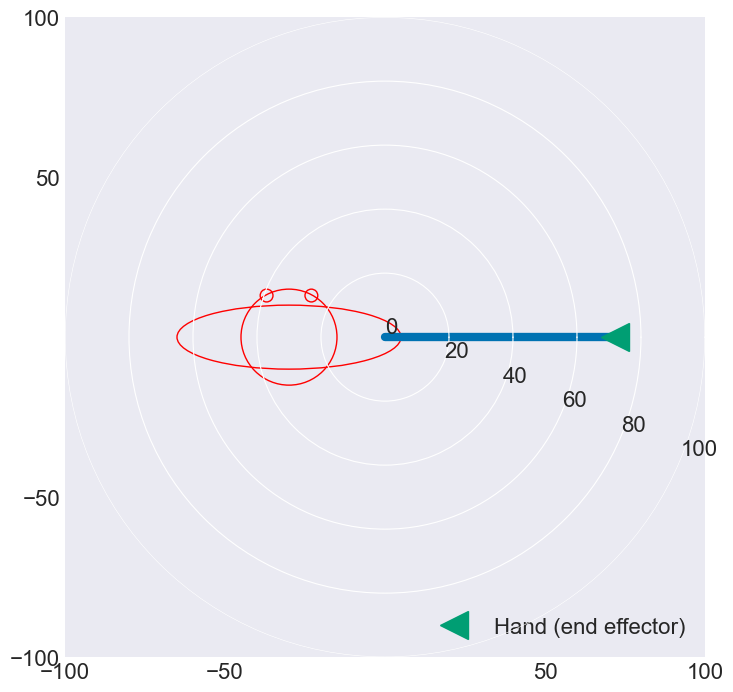

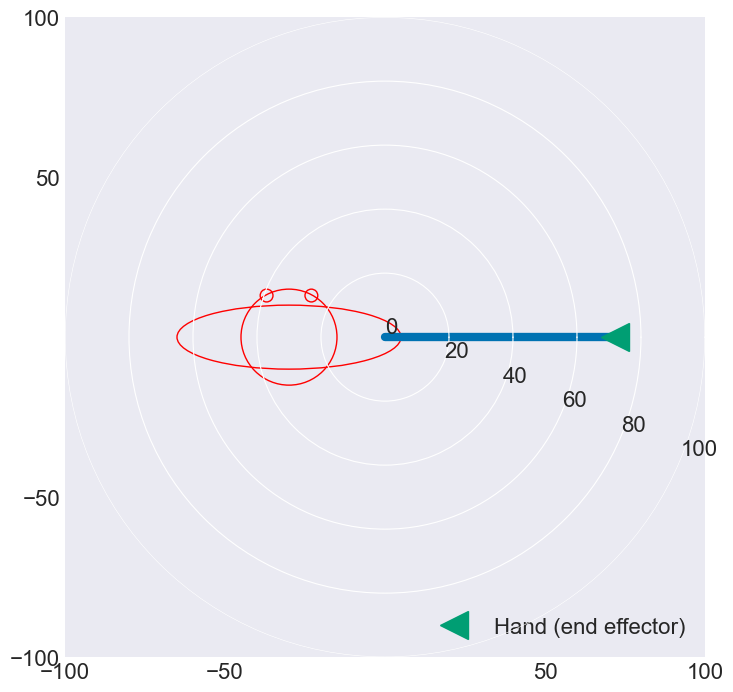

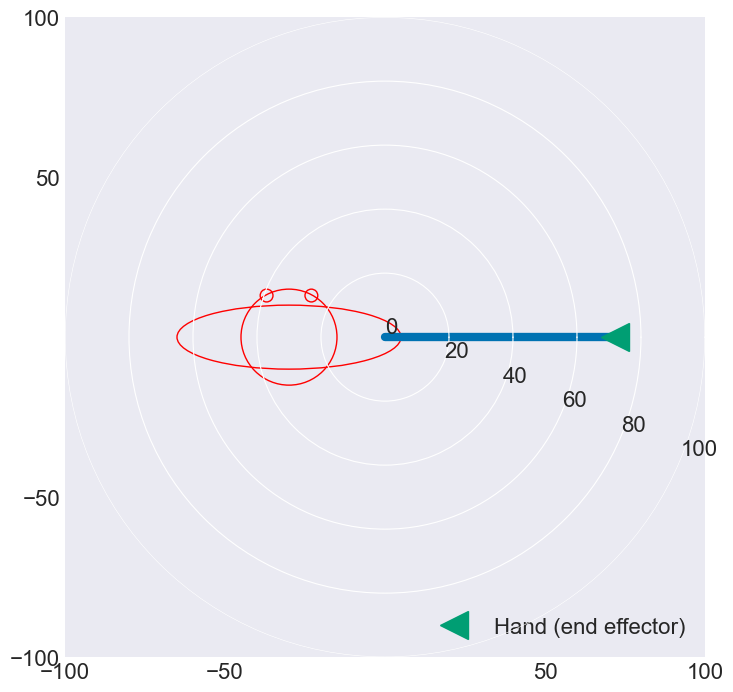

In [14]:
# Plot arm config being tested
%matplotlib inline
arm.plot()

**TODO** Complete the test code below to plot the evidence gathered about the above arm state (i.e. fully extended to the right = 0° for all joints) based on the computed `net_in` values.

If everything is working, you should get a 4x1 set of vertically stacked subplots. The peak evidence in each plot should be different positions, but the dashed vertical line (showing the true value) should intersect the peak. The dashed line may not intersect perfectly for the movement direction. The evidence values should be large (~3500 for joints and ~800 for the movement direction).

In [ ]:
# TODO: Create MotorNeurons object based on the current set of joints


# TODO: Compute the net_in. You can just hardcode the current joint angles
# and movement direction:
# joint angles is just an array of 3 0s.
# movement direction we are assuming is up (π/2)


# Plug in the net_in and one 4 item list of the actual joint angles and move direction
# (move direction is last) into the MotorNeuron plot method.
# Hard coding this list is fine here.
mn.plot(mn_net_in, [0, 0, 0, np.pi/2])

### 3c. Questions

**Question 1:** Why are we expecting the peaks in each plot to line up with the vertical dashed lines?

**Question 2:** Why are the peaks appear in different horizontal positions in the different plots?

**Question 3:** How would you expect the arm workspace and evidence plots the change if we changed the wrist joint angle to $\pi/4$ (+45°)?

**Answer 1:**

**Answer 2:**

**Answer 3:**

### 3d. Implement motorneuron activation (`net_act`) and `forward` methods

As in previous projects this semester, the motorneurons undergo a competitive process and the `net_act` is the same as the `net_in` for the neurons that produce the top `n_winners` (e.g. 3) `net_in` values. The other activations are set to 0.

#### Test: `net_act` numeric

In [ ]:
joints = [Joint('j1', 0, 1, angle_limits=(-7, -3)),
          Joint('j2', 1, 2, angle_limits=(10, 15)),
          Joint('j3', 2, 3, angle_limits=(-2, 2))]

neurons = MotorNeurons(joints, n_joint_angle_prefs=1, n_dir_angle_prefs=5)
# Set preferred angles to make sure everyone's preferred angles are the same in this test
pref_angles = np.array([[-7.   , -7.   , -7.   , -7.   , -7.   ],
       [10.   , 10.   , 10.   , 10.   , 10.   ],
       [-2.   , -2.   , -2.   , -2.   , -2.   ],
       [-3.142, -1.885, -0.628,  0.628,  1.885]])
neurons.set_pref_angles(pref_angles)
print(75*'*')
print(f'Test 1:\nThe net activations of your neurons are')
print(f' {neurons.net_act(neurons.net_in(np.array([-7, 10, -2]), -3.142))}')
print(f'and they should be (different order is ok):\n 1.  0.9 0.8 0.  0. ]')

print(75*'*')
print(f'Test 2:\nThe net activations of your neurons are')
print(f' {neurons.net_act(neurons.net_in(np.array([-7, 10, -2]), 0.628))}')
print(f'and they should be (different order is ok):\n [0.  0.  0.9 1.  0.9]')

print(75*'*')
print(f'Test 3:\nThe net activations of your neurons are')
print(f' {neurons.net_act(neurons.net_in(np.array([-3.86, 13.14, 1.14]), 0))}')
print(f'and they should be (different order is ok):\n [0.    0.    1.    1.    0.501]')

print(75*'*')
print(f'Test 4:\nThe net activations of your neurons are')
print(f' {neurons.net_act(neurons.net_in(np.array([-7, 13.14, 1.14]), 1.256))}')
print(f'and they should be (different order is ok):\n [0.    0.    0.778 1.    1.   ]')

neurons = MotorNeurons(joints, n_joint_angle_prefs=1, n_dir_angle_prefs=5, n_winners=5)
# Set preferred angles to make sure everyone's preferred angles are the same in this test
pref_angles = np.array([[-7.   , -7.   , -7.   , -7.   , -7.   ],
       [10.   , 10.   , 10.   , 10.   , 10.   ],
       [-2.   , -2.   , -2.   , -2.   , -2.   ],
       [-3.142, -1.885, -0.628,  0.628,  1.885]])
neurons.set_pref_angles(pref_angles)

print(75*'*')
print(f'Test 5:\nThe net activations of your neurons are')
print(f' {neurons.net_act(neurons.net_in(np.array([-7, 13.14, 1.14]), 1.256))}')
print(f'and they should be (different order is ok):\n [0.334 0.556 0.778 1.    1.   ]')

#### Test: `net_act` visual

Running the following test code should produce a similar set of 4x1 evidence plots for each angle, but the peaks should be much sharper.

In [ ]:
joints, hand = create_joints_and_hand_for_visual_test()
arm = Arm(joints, hand, None)
mn = MotorNeurons(joints)
mn_net_act = mn.forward(np.array([0, 0, 0]), np.pi/2)
mn.plot(mn_net_act, [0, 0, 0, np.pi/2])

### 3e. Questions

**Question 4:** Why is there one "evidence" value of 3 in the shoulder, elbow, and wrist plots?

**Question 5:** What does the move dir plot tell us about the hand movement preferences of the competition winners?

**Answer 4:**

**Answer 5:**

## Task 4: Outstar network

The Outstar network (`Outstar` class in `outstar.py`) learns what muscle activations are necessary to move the arm toward the target *given* the arm's current state. Remember, the **source cells** are the **motorneurons** and the **sink cells** are the **muscles**.

The goal of this task is to implement the Outstar network and explore how it works with simple "fake" examples. The next task will involve actually training the network to move the model arm.

In [ ]:
from joint import Joint
from motor_neurons import MotorNeurons
from muscles import Muscles
from outstar import Outstar
from viz import plot_wts

### 4a. Implement `Outstar` class through `train_step`

The Outstar learning rule implemented in `update_wts` is:

$$
wts_{jk} (t) = wts_{jk}(t-1) + \eta x_j \left(y_k - wts_{jk} \right)
$$

where $x_j$ is the `net_act` of the source cell $j$, $y_k$ is the `net_act` of the sink cell $k$, and $\eta$ is the learning rate.

#### Test: Outstar training step

In [ ]:
def reset_wts(net):
    net.set_wts(np.array([[0.549, 0.715, 0.603, 0.545, 0.424, 0.646],
       [0.438, 0.892, 0.964, 0.383, 0.792, 0.529],
       [0.568, 0.926, 0.071, 0.087, 0.02 , 0.833],
       [0.778, 0.87 , 0.979, 0.799, 0.461, 0.781],
       [0.118, 0.64 , 0.143, 0.945, 0.522, 0.415]]))

In [ ]:
joints = [Joint('j1', 0, 1, angle_limits=(-7, -3)),
          Joint('j2', 1, 2, angle_limits=(10, 15)),
          Joint('j3', 2, 3, angle_limits=(-2, 2))]

neurons = MotorNeurons(joints, n_joint_angle_prefs=1, n_dir_angle_prefs=5)
# Set preferred angles to make sure everyone's preferred angles are the same in this test
pref_angles = np.array([[-7.   , -7.   , -7.   , -7.   , -7.   ],
       [10.   , 10.   , 10.   , 10.   , 10.   ],
       [-2.   , -2.   , -2.   , -2.   , -2.   ],
       [-3.142, -1.885, -0.628,  0.628,  1.885]])
neurons.set_pref_angles(pref_angles)
muscles = Muscles()

np.random.seed(0)
test_net = Outstar(neurons, muscles, lr=0.1)
print(f'Your wts shape is {test_net.get_wts().shape} and should be (5, 6)')
# Set weights to help ensure everyone gets consistent test results
reset_wts(test_net)

print(75*'*')
print(f'Test 1:\nYour wts are')
test_net.train_step(np.array([1, 0, 0, 0.5, 1, 0]), np.array([-7, 10, -2]), np.pi/2)
print(test_net.get_wts(), 'and they should be:')
print('''
[[0.549 0.715 0.603 0.545 0.424 0.646]
 [0.438 0.892 0.964 0.383 0.792 0.529]
 [0.605 0.848 0.065 0.122 0.103 0.763]
 [0.799 0.787 0.886 0.771 0.512 0.707]
 [0.206 0.576 0.129 0.901 0.57  0.374]]
''')

reset_wts(test_net)
print(75*'*')
print(f'Test 2:\nYour wts are')
test_net.train_step(np.array([0, 1, 0.5, 0, 0, 1]), np.array([-7, 10, -2]), np.pi/2)
print(test_net.get_wts(), 'and they should be:')
print('''
[[0.549 0.715 0.603 0.545 0.424 0.646]
 [0.438 0.892 0.964 0.383 0.792 0.529]
 [0.52  0.932 0.107 0.08  0.018 0.847]
 [0.704 0.882 0.934 0.723 0.417 0.802]
 [0.106 0.676 0.179 0.851 0.47  0.473]]
''')

reset_wts(test_net)
print(75*'*')
print(f'Test 3:\nYour wts are')
test_net.train_step(np.array([0, 1, 0.5, 0, 0, 1]), np.array([-7, 10, -2]), np.pi/4)
print(test_net.get_wts(), 'and they should be:')
print('''
[[0.549 0.715 0.603 0.545 0.424 0.646]
 [0.438 0.892 0.964 0.383 0.792 0.529]
 [0.517 0.933 0.11  0.079 0.018 0.848]
 [0.7   0.883 0.931 0.719 0.415 0.803]
 [0.107 0.673 0.176 0.858 0.474 0.469]]
''')

reset_wts(test_net)
print(75*'*')
print(f'Test 4:\nYour wts are')
test_net.train_step(np.array([0, 1, 0.5, 0, 0, 1]), np.array([-8, 13, -1]), np.pi/4)
print(test_net.get_wts(), 'and they should be:')
print('''
[[0.549 0.715 0.603 0.545 0.424 0.646]
 [0.438 0.892 0.964 0.383 0.792 0.529]
 [0.521 0.932 0.107 0.08  0.018 0.847]
 [0.7   0.883 0.931 0.719 0.415 0.803]
 [0.108 0.671 0.174 0.863 0.476 0.466]]
''')

### 4b. Implement normalization helper function

In [ ]:
def normalize(x, axis=2, eps=1e-8):
    '''Normalizes the input `x` so that `x` sums to 1 along the axis `axis`.
    
    Parameters:
    -----------
    x: ndarray. shape=anything. The input data to normalize.
    axis: int. Axis number to normalize along.
    eps: float. Small number to prevent division by 0.
    
    Returns:
    -----------
    ndarray. shape=same as x. Normalized data.
    '''
    pass

#### Test `normalize`

In [ ]:
x = np.arange(24).reshape([2, 3, 4])

In [ ]:
print(f'Normalizing along axis 0:\n{normalize(x, axis=0)}')
print('should result in:')
print("""[[[0.    0.071 0.125 0.167]
  [0.2   0.227 0.25  0.269]
  [0.286 0.3   0.312 0.324]]

 [[1.    0.929 0.875 0.833]
  [0.8   0.773 0.75  0.731]
  [0.714 0.7   0.687 0.676]]]""")

In [ ]:
print(f'Normalizing along axis 1:\n{normalize(x, axis=1)}')
print('should result in:')
print("""  [0.333 0.333 0.333 0.333]
  [0.667 0.6   0.556 0.524]]

 [[0.25  0.255 0.259 0.263]
  [0.333 0.333 0.333 0.333]
  [0.417 0.412 0.407 0.404]]]""")

In [ ]:
print(f'Normalizing along axis 2:\n{normalize(x, axis=2)}')
print('should result in:')
print("""[[[0.    0.167 0.333 0.5  ]
  [0.182 0.227 0.273 0.318]
  [0.211 0.237 0.263 0.289]]

 [[0.222 0.241 0.259 0.278]
  [0.229 0.243 0.257 0.271]
  [0.233 0.244 0.256 0.267]]]""")

### 4c. Training experiment

The goal of this experiment is to train an Outstar network on simple inputs and analyze what is learned.

- The network is composed of **2 source neurons** (think: motorneurons) and **4 sink neurons** (think: muscles).
- The source neuron (motorneuron) acts are simply `[2, 0]`, `[0, 2]`, `[2, 0]`, `[0, 2]`, ... over and over again.
- The sink (muscle) acts also follow a repeating sequence: `[8, 6, 4, 1]`, `[4, 4, 1, 8]`, `[8, 6, 4, 1]`, `[4, 4, 1, 8]`, ... over and over again.
- The test code below generates the source and sink activations for 500 training steps.

**TODO:**
1. Write the training loop to complete the test code below. This should update the network weights for a total of `n_steps` steps based on the source/sink activations appropriate for the current training step, recording the weights in `wt_hist` after each update.
2. Create a plot (calling `plot_wts` in `viz.py`) showing the raw and normalized weights **coming from source neuron 0** over time (i.e. over training iteration). The normalized version of the weights should be normalized so that the sink weights attached to each source cell should sum to 1.
3. Create a plot (calling `plot_wts` in `viz.py`) showing the raw and normalized weights **coming from source neuron 1** over time (i.e. over training iteration). The normalized version of the weights should be normalized so that the sink weights attached to each source cell should sum to 1.

In [ ]:
np.random.seed(0)

joints, _ = create_joints_and_hand_for_visual_test()
src = MotorNeurons(joints, n_joint_angle_prefs=1, n_dir_angle_prefs=2)
snk = Muscles(n_ag_ant_pairs=2)

net = Outstar(src, snk, lr=0.01)

# Make source act
n_steps = 500
src_act = 2*np.ones([n_steps, 2])
src_act[np.arange(0, n_steps, 2), 1] = 0.0
src_act[np.arange(1, n_steps, 2), 0] = 0.0

# Make sink act
snk_act = np.zeros([n_steps, 4])
snk_act[np.arange(0, n_steps, 2)] = np.array([8, 6, 4, 1])
snk_act[np.arange(1, n_steps, 2)] = np.array([4, 4, 1, 8])

wt_shape = net.get_wts().shape
wt_hist = np.zeros(np.hstack([n_steps, wt_shape]))
# TODO: Write training loop here



### 4d. Questions

**Question 6:** In your call to `plot_wts` for source cell 0 and 1, use the `feat_vec` keyword argument. You should plug in the **normalized** 4-element feature vector associated with each source cell. For example, the feature vector associated with source cell 0 is `[8, 6, 4, 1]`. Normalization should happen such that each feature vector sums to 1. **What is the relationship between the normalized feature vector and the learned weights?**

**Answer 6:**

### 4e. Prediction experiment

In the cell below, implement the following equation in one line to complete the test code, that predicts the sink activation, given the source activations and final learned weights from the training experiment (Task 4c).

We can compute the sink `net_act` when operating in "prediction mode" according to:

$$
Y = XW
$$

Where `Y` is the matrix of sink activations, `X` is the matrix of source activations, and `W` is the Outstar weight matrix.

In [ ]:
src_activations = np.array([[2, 0], [0, 2]])
# TODO: Compute sink net_act based on source cell activations and learned weights


print('Predicted sink activation:\n', snk_preds)
print('Predicted sink activation (normalized):\n', normalize(snk_preds, axis=1))

### 4f. Questions

**Question 7:** Below, print out the two sink feature vectors used in training (both raw and normalized, mimicking the above prediction print outs. How are the predicted and training sink activations related to each other?

**Question 8:** In your own words, briefly describe what the Outstar network sink activation predictions mean in relation to the source activation inputs?

**Answer 7:**

**Answer 8:**


In [ ]:
print('Sink feature vectors:\n', snk_act[:2])
print('Sink feature vectors (normalized):\n', normalize(snk_act[:2], axis=1))

### 4g. Implement `predict_step` in Outstar network

This predicts the muscle activations (sink) given the motorneuron activation that codes the current state of the arm (source).

To make this work, you should update both the `net_in` and `net_act` methods in `Muscles`:
- **net_in:** If there source motorneuron activations are passed in, the net input is the result of the source activations and learned Outstar wts (use the matrix multiplication equation).
- **net_act:** If there source motorneuron activations are passed in, the net activation should be the same as net input (i.e. the multiplication between the Outstar wts and the source activation).

**Note:** Each `Muscles` object has an instance variable for the Outstar network that "owns" it (should be `self.outstar`).

#### Test: `predict_step`

In [ ]:
joints = [Joint('j1', 0, 1, angle_limits=(-7, -3)),
          Joint('j2', 1, 2, angle_limits=(10, 15)),
          Joint('j3', 2, 3, angle_limits=(-2, 2))]

neurons = MotorNeurons(joints, n_joint_angle_prefs=1, n_dir_angle_prefs=5)
# Set preferred angles to make sure everyone's preferred angles are the same in this test
pref_angles = np.array([[-7.   , -7.   , -7.   , -7.   , -7.   ],
       [10.   , 10.   , 10.   , 10.   , 10.   ],
       [-2.   , -2.   , -2.   , -2.   , -2.   ],
       [-3.142, -1.885, -0.628,  0.628,  1.885]])
neurons.set_pref_angles(pref_angles)
muscles = Muscles()

np.random.seed(0)
test_net = Outstar(neurons, muscles, lr=0.02)
# Set weights to help ensure everyone gets consistent test results
reset_wts(test_net)

print(75*'*')
print(f'Test 1:\nYour predicted muscle activations are')
print(test_net.predict_step(np.array([-8, 13, -1]), np.pi/4))
print('and they should be:\n[1.353 2.198 1.163 1.696 0.933 1.835]')

reset_wts(test_net)
print(75*'*')
print(f'Test 2:\nYour predicted muscle activations are')
print(test_net.predict_step(np.array([-7, 11, -2]), np.pi/2))
print('and they should be:\n[1.325 2.232 1.126 1.772 0.974 1.846]')